In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# To load the environment variable defined in the .env file
from dotenv import load_dotenv
load_dotenv();

In [5]:
RANDOM_SEED = 42

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance


import src.visualization.visualize as VizManager
import src.data.NHLDataManager as DataManager
import src.features.build_features as FeaturesManager

from imblearn.ensemble import BalancedRandomForestClassifier


In [6]:
# Get the dataset
seasons_year = [2015, 2016, 2017, 2018]
features_data_df = FeaturesManager.build_features(seasons_year, with_player_stats=True)

In [7]:
features_data_df[features_data_df['Shooter Goal Ratio Last Season'].isna()].shape

(20974, 37)

In [8]:
names = ['Period', 'Period seconds', 'Shot Type', 'Shot distance', 'Shot angle', 'Is Empty',
         'Rebound', 'Speed From Previous Event', 'Change in Shot Angle', 
         'Shooter Goal Ratio Last Season', 'Goalie Goal Ratio Last Season', 
         'Strength', 'Num players With', 'Num players Against', 'Elapsed time since Power Play',
         'Last event elapsed time', 'Last event distance',  'Last event angle', 
         'Is Goal']


feature_names, target_name = names[0:-2], names[-1]
feature_names = np.array(feature_names)

df_filter = features_data_df[names]

# Be careful with dropna. For example, if we choose the 'Strenght' feature, if will remove all the shots
# df_filter = df_filter.dropna()

shooter_ratio_median = df_filter.loc[:]['Shooter Goal Ratio Last Season'].median()
goalie_ratio_median = df_filter.loc[:]['Goalie Goal Ratio Last Season'].median()

df_filter = df_filter.fillna({'Shooter Goal Ratio Last Season': shooter_ratio_median, 
                              'Goalie Goal Ratio Last Season': goalie_ratio_median})

df_filter.dropna(inplace=True)
# Check if we have any nan values left
df_filter[df_filter.isna().any(axis=1)]

,Period,Period seconds,Shot Type,Shot distance,Shot angle,Is Empty,Rebound,Speed From Previous Event,Change in Shot Angle,Shooter Goal Ratio Last Season,Goalie Goal Ratio Last Season,Strength,Num players With,Num players Against,Elapsed time since Power Play,Last event elapsed time,Last event distance,Last event angle,Is Goal


In [9]:
dummy_shot_type = pd.get_dummies(df_filter['Shot Type'], prefix='Shot Type')
df_filter = df_filter.merge(dummy_shot_type, left_index=True, right_index=True)
df_filter = df_filter.drop(columns=['Shot Type'])

dummy_strength = pd.get_dummies(df_filter['Strength'], prefix='Strength')
df_filter = df_filter.merge(dummy_strength, left_index=True, right_index=True)
df_filter = df_filter.drop(columns=['Strength'])

# Update features_name
feature_names = list(df_filter.columns)
feature_names = [f for f in feature_names if f != 'Is Goal']
feature_names = np.array(feature_names)

In [10]:
df_train, df_valid = train_test_split(df_filter, test_size=0.2, random_state=RANDOM_SEED, stratify=df_filter['Is Goal'])

In [11]:
num_rebounds = df_train.query('Rebound == 1').shape[0]
num_no_rebounds = df_train.query('Rebound == 0').shape[0]

ratio_rebound = df_train.query('Rebound == 1 & `Is Goal` == 1').shape[0] / num_rebounds
ratio_no_rebound = df_train.query('Rebound == 0 & `Is Goal` == 1').shape[0] / num_no_rebounds

print(ratio_rebound)
print(ratio_no_rebound)

0.12379387789053402
0.08622058464294438


<AxesSubplot: xlabel='Rebound', ylabel='Count'>

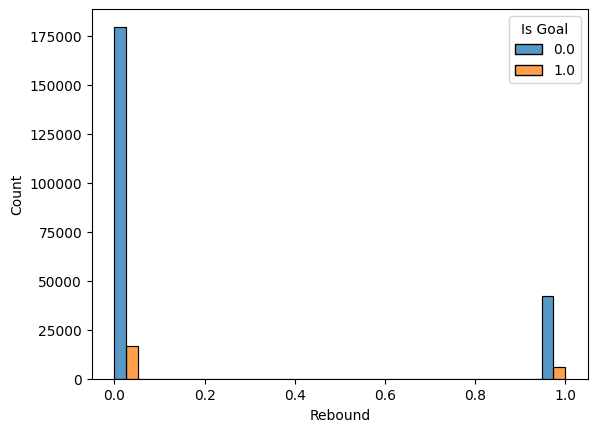

In [12]:
import seaborn as sns
sns.histplot(data = df_train, x = 'Rebound', hue = 'Is Goal', multiple="dodge")

In [42]:
X_train = df_train[feature_names]
y_train = df_train[target_name]

X_valid = df_valid[feature_names]
y_valid = df_valid[target_name]

In [43]:
from imblearn.over_sampling import SMOTE, ADASYN
X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)

print( (y_resampled == 1).sum() / len(y_resampled) )
print( (y_resampled == 0).sum() / len(y_resampled) )

print( (y_train == 1).sum() / len(y_train) )
print( (y_train == 0).sum() / len(y_train) )

0.5
0.5
0.09360792202269977
0.9063920779773003


In [44]:
forest = RandomForestClassifier(random_state=RANDOM_SEED, class_weight='balanced')
forest.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [46]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
y_pred = forest.predict(X_valid)
# print(precision_recall_fscore_support(y_valid, y_pred,  average='macro'))

print( (y_valid == 1).sum())
tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel()
tn, fp, fn, tp

# y_pred = forest.predict(X_train)
# print(precision_recall_fscore_support(y_train, y_pred,  average='micro'))

# VizManager.plot_all_figures([(forest, 'random forest', X_valid, y_valid)])

5724


(55249, 173, 5245, 479)

### Feature importance based on mean decrease in impurity

In [47]:
start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.323 seconds


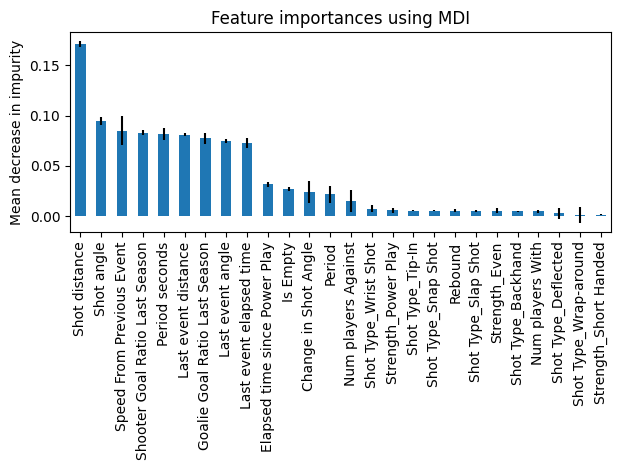

In [48]:
forest_importances = pd.Series(importances, index=forest.feature_names_in_).sort_values(ascending=False)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [49]:
# Rebound does not seem very informative.
features_data_df[['Rebound', 'Is Goal', 'Last event elapsed time']].query('Rebound == 1').sample(10)

# Elapsed time with the last event should be shorter for the shot to be considered as a rebound
# Redefine a rebound a little differently
df_train_2 = df_train.copy()
df_train_2['Rebound'] = ( (df_train_2['Rebound'] == 1) & (df_train_2['Last event elapsed time'] <= 3)).astype(int)
df_train_2[['Rebound', 'Is Goal', 'Last event elapsed time']].query('Rebound == 1').sample(10)

num_rebounds = df_train_2.query('Rebound == 1').shape[0]
num_no_rebounds = df_train_2.query('Rebound == 0').shape[0]

ratio_rebound = df_train_2.query('Rebound == 1 & `Is Goal` == 1').shape[0] / num_rebounds
ratio_no_rebound = df_train_2.query('Rebound == 0 & `Is Goal` == 1').shape[0] / num_no_rebounds

print(ratio_rebound)
print(ratio_no_rebound)

0.270895918006715
0.08500595886241458


Elapsed time to compute the importances: 0.121 seconds


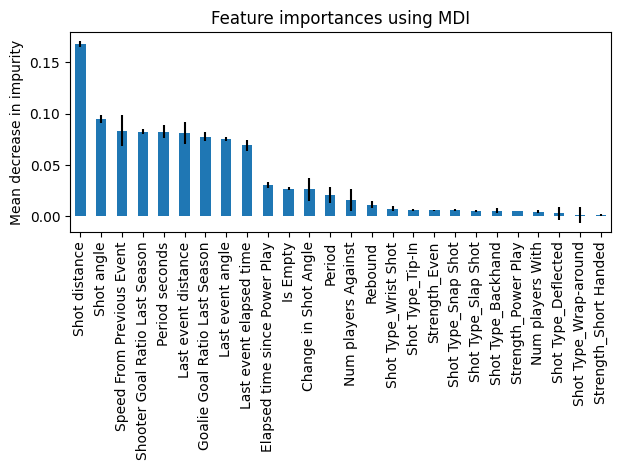

In [50]:
X_train_2 = df_train_2[feature_names]
y_train_2 = df_train_2[target_name]

forest_2 = RandomForestClassifier(random_state=RANDOM_SEED, class_weight='balanced')
forest_2.fit(X_train_2, y_train_2)

start_time = time.time()
importances_2 = forest_2.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest_2.estimators_], axis=0)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances_2 = pd.Series(importances_2, index=forest_2.feature_names_in_).sort_values(ascending=False)
fig, ax = plt.subplots()
forest_importances_2.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### Feature importance based on feature permutation

In [51]:

start_time = time.time()
result = permutation_importance(forest, X_valid, y_valid, n_repeats=6, random_state=RANDOM_SEED, n_jobs=1)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names).sort_values(ascending=False)

Elapsed time to compute the importances: 357.518 seconds


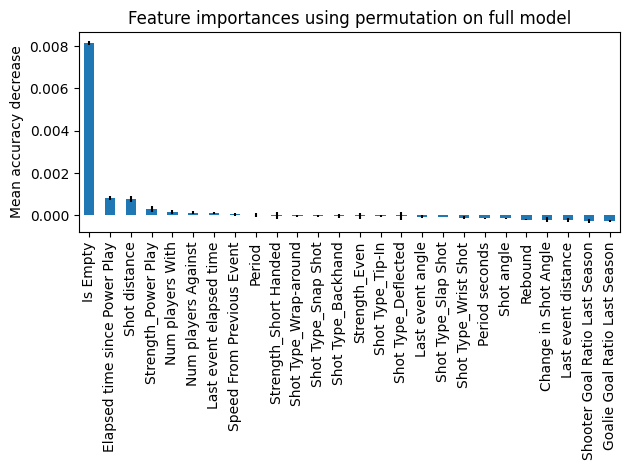

In [53]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()